* train : 2103 장 / validation : 555 장 / test : 556 장
* learning rate : 1e-3
* epoch = 50
* param : set 1
* optimizer : Adam
* scheduler : None
* result
    - {Train Loss: 70.0215, Train PSNR: 29.9785, Train SSIM: 0.9274}
    - {Val Loss: 70.9691, Val PSNR: 29.0309, Val SSIM: 0.9228}
    - {Test Loss: 70.9692, Test PSNR: 29.0308, Test SSIM: 0.9212}

In [1]:
%%capture
!pip install torchsummary
!pip install torchinfo

In [2]:
import os
import torch
import numpy as np
import random

from PIL import Image
from torch import nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchmetrics.image import StructuralSimilarityIndexMeasure
from glob import glob
import gc

root_path = glob('../../*/input/', recursive = True)
data_path = glob(f'{root_path[0]}/*/DBlur', recursive = True)[0]

dataset_path = os.path.join(data_path, 'Gopro')

class Configs:
    size = 256
    batch_size = 16
    num_workers = 4

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    mode = ['train','valid', 'test']
    epoch = 50
    lr = 1e-3

class Transform:
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    
    transforms = transforms.Compose([
        transforms.Resize((Configs.size, Configs.size), Image.BICUBIC),
        transforms.RandomHorizontalFlip(0.2),
        transforms.RandomVerticalFlip(0.2),
        transforms.ToTensor(),
        #transforms.Normalize(mean, std), #Normalize 적용 시 PSNR, SSIM 모두 떨어짐
    ])

## Dataset Pre-processing

In [3]:
class ImageDataset(Dataset):
    
    def __init__(self, dataset_path, mode, transforms):
        self.mode = mode
        self.dataset_path = dataset_path
        
        self.data_path = os.path.join(self.dataset_path, self.mode)
        self.transforms = transforms

    def __getitem__(self, index):

        seed = np.random.randint(2147483647) #transforms random seed fix
    
        noise_image = Image.open(glob(os.path.join(self.data_path, 'blur') + '/*.png')[index]).convert('RGB')
        clean_image = Image.open(glob(os.path.join(self.data_path, 'sharp') + '/*.png')[index]).convert('RGB')

        if self.transforms is not None:
            torch.manual_seed(seed)
            noise_image = self.transforms(noise_image)
            
            torch.manual_seed(seed)
            clean_image = self.transforms(clean_image)
        
        return noise_image, clean_image

    def __len__(self):
        return len(glob(os.path.join(self.data_path , 'blur') + '/*.png'))
    

## Define Dataloader [Test dataset Split -> Valid + Test Dataset  (ratio = 1:1)]

In [4]:
train_dataset = ImageDataset(dataset_path = dataset_path, mode = Configs.mode[0], transforms = Transform.transforms)
test_dataset = ImageDataset(dataset_path = dataset_path, mode = Configs.mode[2], transforms = Transform.transforms)

test_dataset_size = len(test_dataset)
validation_size = int(test_dataset_size * 0.5)
test_size = test_dataset_size - validation_size

validation_dataset, test_dataset = random_split(test_dataset, [validation_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size = Configs.batch_size, shuffle = True, num_workers = Configs.num_workers)
validation_dataloader = DataLoader(validation_dataset, batch_size = Configs.batch_size, shuffle = True, num_workers = Configs.num_workers)
test_dataloader = DataLoader(test_dataset, batch_size = Configs.batch_size, shuffle = False, num_workers = Configs.num_workers)

## Dataset Check

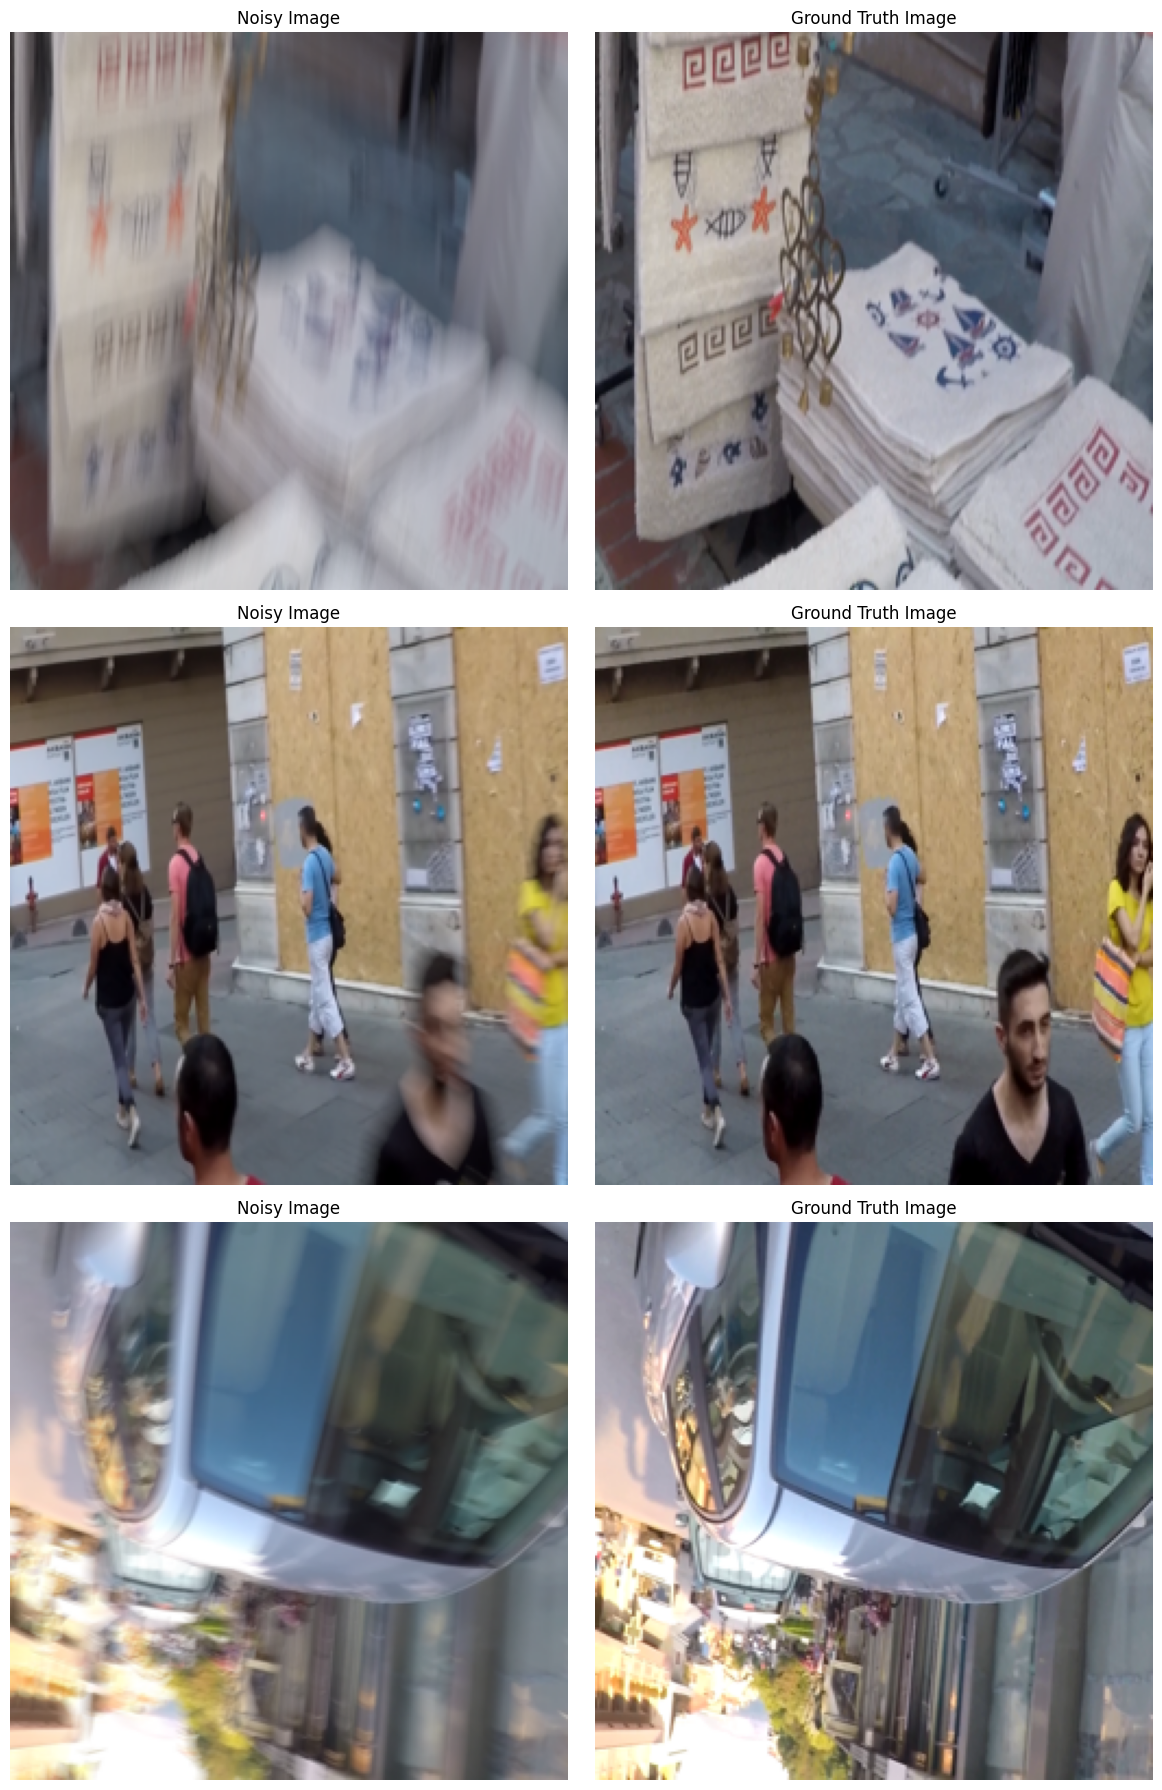

In [5]:
from matplotlib import pyplot as plt

num_images_to_display = 3
plt.figure(figsize=(12, 6*num_images_to_display))

dataset_path = os.path.join(data_path, 'Gopro')
train_data_path = os.path.join(dataset_path, 'train')

# Permute axis for each image pair before displaying
for i in range(num_images_to_display):
    # Permute axis for noisy image
    seed = np.random.randint(2147483647) 
    
    noise_image = Image.open(glob(os.path.join(train_data_path, 'blur') + '/*.png')[i]).convert('RGB')
    clean_image = Image.open(glob(os.path.join(train_data_path, 'sharp') + '/*.png')[i]).convert('RGB')
    
    torch.manual_seed(seed)
    noise_image = Transform.transforms(noise_image)
    torch.manual_seed(seed)
    clean_image = Transform.transforms(clean_image)
    
    # Plot noisy image
    plt.subplot(num_images_to_display, 2, i*2 + 1)
    plt.imshow(noise_image.permute(1, 2, 0))
    plt.title("Noisy Image")
    plt.axis('off')
    
    # Plot ground truth image
    plt.subplot(num_images_to_display, 2, i*2 + 2)
    plt.imshow(clean_image.permute(1, 2, 0))
    plt.title("Ground Truth Image")
    plt.axis('off')

plt.tight_layout()
plt.show()

## NAFNet Architecture Preparation
1. LayerNormFunction
2. NAFNet Intra-Block Architecture
3. NAFNet Inter-Block Architecture

#### 1. LayerNormFunction

In [6]:
class LayerNormFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, weight, bias, eps):
        ctx.eps = eps
        N, C, H, W = x.size()
        mu = x.mean(1, keepdim=True)
        var = (x - mu).pow(2).mean(1, keepdim=True)
        y = (x - mu) / (var + eps).sqrt()
        ctx.save_for_backward(y, var, weight)
        y = weight.view(1, C, 1, 1) * y + bias.view(1, C, 1, 1)
        return y

    @staticmethod
    def backward(ctx, grad_output):
        eps = ctx.eps

        N, C, H, W = grad_output.size()
        y, var, weight = ctx.saved_variables
        g = grad_output * weight.view(1, C, 1, 1)
        mean_g = g.mean(dim=1, keepdim=True)

        mean_gy = (g * y).mean(dim=1, keepdim=True)
        gx = 1. / torch.sqrt(var + eps) * (g - y * mean_gy - mean_g)
        return gx, (grad_output * y).sum(dim=3).sum(dim=2).sum(dim=0), grad_output.sum(dim=3).sum(dim=2).sum(
            dim=0), None

class LayerNorm2d(nn.Module):

    def __init__(self, channels, eps=1e-6):
        super(LayerNorm2d, self).__init__()
        self.register_parameter('weight', nn.Parameter(torch.ones(channels)))
        self.register_parameter('bias', nn.Parameter(torch.zeros(channels)))
        self.eps = eps

    def forward(self, x):
        return LayerNormFunction.apply(x, self.weight, self.bias, self.eps)

#### 2. NAFNet Intra-Block Architecture

In [7]:
class Local_Base():
    def convert(self, *args, train_size, **kwargs):
        replace_layers(self, *args, train_size=train_size, **kwargs)
        imgs = torch.rand(train_size)
        with torch.no_grad():
            self.forward(imgs)

# Channel 방향으로 쪼개서 Element-wise mul 진행
class SimpleGate(nn.Module):
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        return x1 * x2

class NAFBlock(nn.Module):
    def __init__(self, c, DW_Expand=2, FFN_Expand=2, drop_out_rate=0.):
        super().__init__()
        dw_channel = c * DW_Expand # Embedding 과정과, Non-linear 과정에서 정보유실을 방지하기위해 Expansion함 // 여기서는 SCA(채널쪼개서 서로 곱하는)부분에서 발생하는 non-linearity에서의 정보유실 방지
        self.conv1 = nn.Conv2d(in_channels=c, out_channels=dw_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=dw_channel, out_channels=dw_channel, kernel_size=3, padding=1, stride=1, groups=dw_channel,
                               bias=True)
        self.conv3 = nn.Conv2d(in_channels=dw_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        
        # Simplified Channel Attention
        self.sca = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels=dw_channel // 2, out_channels=dw_channel // 2, kernel_size=1, padding=0, stride=1,
                      groups=1, bias=True),
        )

        # SimpleGate
        self.sg = SimpleGate()

        ffn_channel = FFN_Expand * c
        self.conv4 = nn.Conv2d(in_channels=c, out_channels=ffn_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=ffn_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        self.norm1 = LayerNorm2d(c)
        self.norm2 = LayerNorm2d(c)

        self.dropout1 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()
        self.dropout2 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()

        # Normalization 파라미터, 단순히 정규화해서 ReLU를 통과시키면, 대부분의 Param이 소멸되므로, beta와 같은 bias 추가
        self.beta = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)
        self.gamma = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)

    def forward(self, inp):
        x = inp

        x = self.norm1(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.sg(x)
        x = x * self.sca(x)
        x = self.conv3(x)

        x = self.dropout1(x)

        y = inp + x * self.beta

        x = self.conv4(self.norm2(y))
        x = self.sg(x)
        x = self.conv5(x)

        x = self.dropout2(x)

        return y + x * self.gamma

#### 3. NAFNet Inter-Block Architecture

In [8]:
class NAFNet(nn.Module):

    def __init__(self, img_channel=3, width=16, middle_blk_num=1, enc_blk_nums=[], dec_blk_nums=[]):
        super().__init__()

        self.intro = nn.Conv2d(in_channels=img_channel, out_channels=width, kernel_size=3, padding=1, stride=1, groups=1,
                              bias=True)
        self.ending = nn.Conv2d(in_channels=width, out_channels=img_channel, kernel_size=3, padding=1, stride=1, groups=1,
                              bias=True)

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.middle_blks = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()

        chan = width
        for num in enc_blk_nums:
            self.encoders.append(
                nn.Sequential(
                    *[NAFBlock(chan) for _ in range(num)]
                )
            )
            self.downs.append(
                nn.Conv2d(chan, 2*chan, 2, 2)
            )
            chan = chan * 2

        self.middle_blks = \
            nn.Sequential(
                *[NAFBlock(chan) for _ in range(middle_blk_num)]
            )

        for num in dec_blk_nums:
            self.ups.append(
                nn.Sequential(
                    nn.Conv2d(chan, chan * 2, 1, bias=False),
                    nn.PixelShuffle(2)
                )
            )
            chan = chan // 2
            self.decoders.append(
                nn.Sequential(
                    *[NAFBlock(chan) for _ in range(num)]
                )
            )

        self.padder_size = 2 ** len(self.encoders)

    def forward(self, inp):
        B, C, H, W = inp.shape
        inp = self.check_image_size(inp)

        x = self.intro(inp)

        encs = []

        for encoder, down in zip(self.encoders, self.downs):
            x = encoder(x)
            encs.append(x)
            x = down(x)

        x = self.middle_blks(x)

        for decoder, up, enc_skip in zip(self.decoders, self.ups, encs[::-1]):
            x = up(x)
            x = x + enc_skip
            x = decoder(x)

        x = self.ending(x)
        x = x + inp

        return x[:, :, :H, :W]

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.padder_size - h % self.padder_size) % self.padder_size
        mod_pad_w = (self.padder_size - w % self.padder_size) % self.padder_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h))
        return x

## Param Change

In [9]:
img_channel = 3

width = 32

#default set
#enc_blks = [1, 1, 1, 28]
#middle_blk_num = 1
#dec_blks = [1, 1, 1, 1]

#set 1
enc_blks = [1, 1, 1, 1]
middle_blk_num = 1
dec_blks = [1, 1, 1, 1]

#set 2
# enc_blks = [2, 2, 4, 8]
# middle_blk_num = 12
# dec_blks = [2, 2, 2, 2]

## Model Define & Param check

In [10]:
model = NAFNet(img_channel=img_channel, width=width, middle_blk_num=middle_blk_num,
               enc_blk_nums=enc_blks, dec_blk_nums=dec_blks).to(Configs.device)

inp_shape = (3, 256, 256)

def get_model_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


# Calculate and print model parameters
total_params, trainable_params = get_model_params(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 4497507
Trainable parameters: 4497507


In [ ]:
from torchsummary import summary
result = summary(model, (3, 256 ,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       LayerNorm2d-2         [-1, 32, 256, 256]              64
            Conv2d-3         [-1, 64, 256, 256]           2,112
            Conv2d-4         [-1, 64, 256, 256]             640
        SimpleGate-5         [-1, 32, 256, 256]               0
 AdaptiveAvgPool2d-6             [-1, 32, 1, 1]               0
            Conv2d-7             [-1, 32, 1, 1]           1,056
            Conv2d-8         [-1, 32, 256, 256]           1,056
          Identity-9         [-1, 32, 256, 256]               0
      LayerNorm2d-10         [-1, 32, 256, 256]              64
           Conv2d-11         [-1, 64, 256, 256]           2,112
       SimpleGate-12         [-1, 32, 256, 256]               0
           Conv2d-13         [-1, 32, 256, 256]           1,056
         Identity-14         [-1, 32, 2

## Loss function with PSNR, SSIM

In [12]:
class loss_Calc():
    def __init__(self,output_img, sharp_img, device):
        self.output_img = output_img
        self.sharp_img = sharp_img
        self.device = device
        self.data_range = 1.0
    
    def ssim_calc(self):
        ssim = StructuralSimilarityIndexMeasure(self.data_range).to(self.device)
        return ssim(self.output_img, self.sharp_img)
    
    def mse_calc(self):
        mse = F.mse_loss(self.output_img, self.sharp_img)
        return mse

    def psnr_calc(self):
        psnr = 20*torch.log10(self.data_range / torch.sqrt(self.mse_calc()))
        return psnr
        
    def loss_func(self):
        loss_val = 100-self.psnr_calc() #PSNR값은 올라가고 loss값은 내려가야 되기 때문?
        return loss_val

    def metrics(self):
        return self.ssim_calc(), self.mse_calc(), self.psnr_calc(), self.loss_func()

## Train & Evaluation

In [13]:
class Trainer():
    def __init__(self, model, batch_size, epoch, lr, device, mode, T_max = 100):
        self.model = model
        self.batch_size = batch_size
        self.epoch = epoch
        self.lr = lr
        self.device = device
        self.mode = mode
        self.T_max = T_max
        self.opt = torch.optim.Adam(self.model.parameters(), lr = self.lr)
        self.sch = torch.optim.lr_scheduler.StepLR(optimizer = self.opt, step_size=10, gamma=0.1)
        #self.sch = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer = self.opt, T_max = self.T_max, eta_min = 0)
        self.history = {'train_loss' : [],
                        'valid_loss' : [],
                        'train_psnr' : [],
                        'valid_psnr' : [],
                        'train_ssim' : [],
                        'valid_ssim' : []}

    def history_update(self, mode, metric_dict):
        for k, v in self.history.items():
            if mode in k:
                metric_type = k.split('_')[-1]
        
                for x, y in metric_dict.items():
                    if metric_type in x:
                        self.history[k].append(y)
                
    def total_metric(self, loss, psnr, ssim):
        self.total_ssim += ssim.item()
        self.total_psnr += psnr.item()
        self.total_loss += loss.item()


    def avg_metric(self, length, mode):
        avg_loss = self.total_loss / length
        avg_psnr = self.total_psnr / length
        avg_ssim = self.total_ssim / length

        if mode == 'train':
            print(f"\nTrain Loss: {avg_loss:.4f}, Train PSNR: {avg_psnr:.4f}, Train SSIM: {avg_ssim:.4f}")
            
        elif mode == 'valid':
            print(f"Val Loss: {avg_loss:.4f}, Val PSNR: {avg_psnr:.4f}, Val SSIM: {avg_ssim:.4f}")

        return {'avg_loss' : avg_loss , 'avg_psnr' : avg_psnr, 'avg_ssim' : avg_ssim}

    def train(self, dataloader, mode, cur_epoch):
        self.total_loss, self.total_psnr, self.total_ssim = 0,0,0
        self.model.train()
        progress_bar = tqdm(dataloader)
        
        for batch_idx, (noise, clean) in enumerate(progress_bar):
            gc.collect()

            self.opt.zero_grad()

            inputs, labels = noise.to(self.device), clean.to(self.device)
            outputs = self.model(inputs)

            # Evaluate with various Metric Index
            ssim, mse, psnr, loss = loss_Calc(output_img = outputs, sharp_img = labels, device = self.device).metrics()

            # Total Metric Values Compusing
            self.total_metric(loss, psnr, ssim)
            loss.backward()
            self.opt.step()

            progress_bar.set_description(f'Step {cur_epoch} [{batch_idx+1}/{len(dataloader)}]')
            progress_bar.set_postfix(loss = loss.item(), psnr = psnr.item(), ssim = ssim.item())

        # Average Metric Values Compusing
        metric_dict = self.avg_metric(length = len(dataloader), mode = mode)

        # For Visualization of Loss & Various Metrics with Graph
        self.history_update(mode, metric_dict)

    def evaluate(self, dataloader, mode):
        # Construct dataloader comparing function for applying k-folds system with valid_dataloader
        
        self.total_loss, self.total_psnr, self.total_ssim = 0,0,0
        self.model.eval()
        
        with torch.no_grad():
            for noise, clean in dataloader:
                gc.collect()

                inputs, labels = noise.to(self.device), clean.to(self.device)
                outputs = self.model(inputs)

                ssim, mse, psnr, loss = loss_Calc(output_img = outputs, sharp_img = labels, device = self.device).metrics()

                self.total_metric(loss, psnr, ssim)

            metric_dict = self.avg_metric(length = len(dataloader), mode = mode)
            self.history_update(mode, metric_dict)
        
    def fit(self,train_dataloader, test_dataloader):
        self.model.to(self.device)
        for i in range(self.epoch):
            self.train(train_dataloader, self.mode[0], cur_epoch = i + 1)
            self.evaluate(test_dataloader,self.mode[1])
            #self.sch.step()

        

In [14]:
trainer = Trainer(model = model, batch_size = Configs.batch_size, epoch = Configs.epoch, lr = Configs.lr, device = Configs.device, mode = Configs.mode)

model_fit = trainer.fit(train_dataloader, validation_dataloader)

  0%|          | 0/132 [00:00<?, ?it/s]/tmp/ipykernel_30/698487685.py:19: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  y, var, weight = ctx.saved_variables
Step 1 [132/132]: 100%|██████████| 132/132 [01:56<00:00,  1.13it/s, loss=74.1, psnr=25.9, ssim=0.835]



Avg Loss: 74.6299, Avg PSNR: 25.3701, Avg SSIM: 0.8341
Val Loss: 73.5730, Val PSNR: 26.4270, Val SSIM: 0.8721


Step 2 [132/132]: 100%|██████████| 132/132 [02:00<00:00,  1.09it/s, loss=74.1, psnr=25.9, ssim=0.865]


Avg Loss: 73.8700, Avg PSNR: 26.1300, Avg SSIM: 0.8534


Val Loss: 73.2963, Val PSNR: 26.7037, Val SSIM: 0.8752


Step 3 [132/132]: 100%|██████████| 132/132 [02:00<00:00,  1.09it/s, loss=70.9, psnr=29.1, ssim=0.91] 


Avg Loss: 73.5640, Avg PSNR: 26.4360, Avg SSIM: 0.8603


Val Loss: 73.1927, Val PSNR: 26.8073, Val SSIM: 0.8776


Step 4 [132/132]: 100%|██████████| 132/132 [02:00<00:00,  1.10it/s, loss=72.5, psnr=27.5, ssim=0.865]


Avg Loss: 73.3634, Avg PSNR: 26.6366, Avg SSIM: 0.8652


Val Loss: 72.9542, Val PSNR: 27.0458, Val SSIM: 0.8804


Step 5 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=71.9, psnr=28.1, ssim=0.906]


Avg Loss: 73.2053, Avg PSNR: 26.7947, Avg SSIM: 0.8690


Val Loss: 72.9890, Val PSNR: 27.0110, Val SSIM: 0.8838


Step 6 [132/132]: 100%|██████████| 132/132 [02:00<00:00,  1.10it/s, loss=68.9, psnr=31.1, ssim=0.939]


Avg Loss: 73.0258, Avg PSNR: 26.9742, Avg SSIM: 0.8742


Val Loss: 72.9290, Val PSNR: 27.0710, Val SSIM: 0.8828


Step 7 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=73.4, psnr=26.6, ssim=0.856]


Avg Loss: 72.8956, Avg PSNR: 27.1044, Avg SSIM: 0.8775


Val Loss: 72.6160, Val PSNR: 27.3840, Val SSIM: 0.8926


Step 8 [132/132]: 100%|██████████| 132/132 [02:00<00:00,  1.10it/s, loss=74.4, psnr=25.6, ssim=0.849]


Avg Loss: 72.7312, Avg PSNR: 27.2688, Avg SSIM: 0.8810


Val Loss: 72.7965, Val PSNR: 27.2035, Val SSIM: 0.8879


Step 9 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=73.4, psnr=26.6, ssim=0.855]


Avg Loss: 72.7149, Avg PSNR: 27.2851, Avg SSIM: 0.8816


Val Loss: 72.4777, Val PSNR: 27.5223, Val SSIM: 0.8922


Step 10 [132/132]: 100%|██████████| 132/132 [02:00<00:00,  1.09it/s, loss=71.2, psnr=28.8, ssim=0.931]


Avg Loss: 72.4988, Avg PSNR: 27.5012, Avg SSIM: 0.8866


Val Loss: 72.3709, Val PSNR: 27.6291, Val SSIM: 0.8991


Step 11 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=72.6, psnr=27.4, ssim=0.89] 


Avg Loss: 72.4302, Avg PSNR: 27.5698, Avg SSIM: 0.8883


Val Loss: 72.3827, Val PSNR: 27.6173, Val SSIM: 0.8983


Step 12 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=72.2, psnr=27.8, ssim=0.888]


Avg Loss: 72.3277, Avg PSNR: 27.6723, Avg SSIM: 0.8905


Val Loss: 72.2917, Val PSNR: 27.7083, Val SSIM: 0.8989


Step 13 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=71.7, psnr=28.3, ssim=0.896]


Avg Loss: 72.2568, Avg PSNR: 27.7432, Avg SSIM: 0.8914


Val Loss: 72.1358, Val PSNR: 27.8642, Val SSIM: 0.9013


Step 14 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=73.8, psnr=26.2, ssim=0.863]


Avg Loss: 72.1470, Avg PSNR: 27.8530, Avg SSIM: 0.8936


Val Loss: 72.3047, Val PSNR: 27.6953, Val SSIM: 0.8987


Step 15 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=72.4, psnr=27.6, ssim=0.896]


Avg Loss: 72.1206, Avg PSNR: 27.8794, Avg SSIM: 0.8941


Val Loss: 72.1734, Val PSNR: 27.8266, Val SSIM: 0.9012


Step 16 [132/132]: 100%|██████████| 132/132 [02:00<00:00,  1.10it/s, loss=73.1, psnr=26.9, ssim=0.853]


Avg Loss: 72.0550, Avg PSNR: 27.9450, Avg SSIM: 0.8955


Val Loss: 72.1655, Val PSNR: 27.8345, Val SSIM: 0.9029


Step 17 [56/132]:  42%|████▏     | 56/132 [00:53<01:07,  1.13it/s, loss=73.9, psnr=26.1, ssim=0.842]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Step 20 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=72.5, psnr=27.5, ssim=0.879]


Avg Loss: 71.7507, Avg PSNR: 28.2493, Avg SSIM: 0.9007


Val Loss: 71.9287, Val PSNR: 28.0713, Val SSIM: 0.9052


Step 21 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.11it/s, loss=68.5, psnr=31.5, ssim=0.948]


Avg Loss: 71.6589, Avg PSNR: 28.3411, Avg SSIM: 0.9024


Val Loss: 71.8081, Val PSNR: 28.1919, Val SSIM: 0.9096


Step 22 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=69.1, psnr=30.9, ssim=0.932]


Avg Loss: 71.5713, Avg PSNR: 28.4287, Avg SSIM: 0.9040


Val Loss: 71.8055, Val PSNR: 28.1945, Val SSIM: 0.9090


Step 23 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=69.7, psnr=30.3, ssim=0.946]


Avg Loss: 71.5246, Avg PSNR: 28.4754, Avg SSIM: 0.9046


Val Loss: 71.8428, Val PSNR: 28.1572, Val SSIM: 0.9080


Step 24 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=70.6, psnr=29.4, ssim=0.891]


Avg Loss: 71.4750, Avg PSNR: 28.5250, Avg SSIM: 0.9059


Val Loss: 71.7712, Val PSNR: 28.2288, Val SSIM: 0.9093


Step 25 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.11it/s, loss=71.8, psnr=28.2, ssim=0.891]


Avg Loss: 71.4002, Avg PSNR: 28.5998, Avg SSIM: 0.9073


Val Loss: 71.8628, Val PSNR: 28.1372, Val SSIM: 0.9087


Step 26 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=69, psnr=31, ssim=0.952]    


Avg Loss: 71.4043, Avg PSNR: 28.5957, Avg SSIM: 0.9070


Val Loss: 71.5511, Val PSNR: 28.4489, Val SSIM: 0.9123


Step 27 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=67.3, psnr=32.7, ssim=0.955]


Avg Loss: 71.2233, Avg PSNR: 28.7767, Avg SSIM: 0.9101


Val Loss: 71.6101, Val PSNR: 28.3899, Val SSIM: 0.9116


Step 28 [132/132]: 100%|██████████| 132/132 [02:00<00:00,  1.10it/s, loss=72.4, psnr=27.6, ssim=0.874]


Avg Loss: 71.2624, Avg PSNR: 28.7376, Avg SSIM: 0.9100


Val Loss: 71.5680, Val PSNR: 28.4320, Val SSIM: 0.9127


Step 29 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=71.3, psnr=28.7, ssim=0.933]


Avg Loss: 71.0378, Avg PSNR: 28.9622, Avg SSIM: 0.9128


Val Loss: 71.7224, Val PSNR: 28.2776, Val SSIM: 0.9105


Step 30 [132/132]: 100%|██████████| 132/132 [02:00<00:00,  1.10it/s, loss=71.3, psnr=28.7, ssim=0.92] 


Avg Loss: 71.0447, Avg PSNR: 28.9553, Avg SSIM: 0.9131


Val Loss: 71.4606, Val PSNR: 28.5394, Val SSIM: 0.9125


Step 31 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=72, psnr=28, ssim=0.904]    


Avg Loss: 70.9924, Avg PSNR: 29.0076, Avg SSIM: 0.9139


Val Loss: 71.3983, Val PSNR: 28.6017, Val SSIM: 0.9159


Step 32 [132/132]: 100%|██████████| 132/132 [02:00<00:00,  1.10it/s, loss=70.5, psnr=29.5, ssim=0.912]


Avg Loss: 71.0078, Avg PSNR: 28.9922, Avg SSIM: 0.9134


Val Loss: 71.4612, Val PSNR: 28.5388, Val SSIM: 0.9133


Step 33 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=69.4, psnr=30.6, ssim=0.944]


Avg Loss: 70.8540, Avg PSNR: 29.1460, Avg SSIM: 0.9161


Val Loss: 71.3919, Val PSNR: 28.6081, Val SSIM: 0.9178


Step 34 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=69.4, psnr=30.6, ssim=0.935]


Avg Loss: 70.7885, Avg PSNR: 29.2115, Avg SSIM: 0.9172


Val Loss: 71.1842, Val PSNR: 28.8158, Val SSIM: 0.9192


Step 35 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.11it/s, loss=70.4, psnr=29.6, ssim=0.913]


Avg Loss: 70.7178, Avg PSNR: 29.2822, Avg SSIM: 0.9178


Val Loss: 71.2516, Val PSNR: 28.7484, Val SSIM: 0.9177


Step 36 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=71, psnr=29, ssim=0.916]    


Avg Loss: 70.7079, Avg PSNR: 29.2921, Avg SSIM: 0.9182


Val Loss: 71.2171, Val PSNR: 28.7829, Val SSIM: 0.9200


Step 37 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=71.2, psnr=28.8, ssim=0.912]


Avg Loss: 70.6675, Avg PSNR: 29.3325, Avg SSIM: 0.9185


Val Loss: 71.3400, Val PSNR: 28.6600, Val SSIM: 0.9190


Step 38 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.11it/s, loss=72.2, psnr=27.8, ssim=0.878]


Avg Loss: 70.6186, Avg PSNR: 29.3814, Avg SSIM: 0.9193


Val Loss: 71.1708, Val PSNR: 28.8292, Val SSIM: 0.9197


Step 39 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=70.6, psnr=29.4, ssim=0.898]


Avg Loss: 70.5388, Avg PSNR: 29.4612, Avg SSIM: 0.9201


Val Loss: 71.2262, Val PSNR: 28.7738, Val SSIM: 0.9198


Step 40 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=68.2, psnr=31.8, ssim=0.941]


Avg Loss: 70.5281, Avg PSNR: 29.4719, Avg SSIM: 0.9210


Val Loss: 71.3770, Val PSNR: 28.6230, Val SSIM: 0.9168


Step 41 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=72.7, psnr=27.3, ssim=0.876]


Avg Loss: 70.4274, Avg PSNR: 29.5726, Avg SSIM: 0.9217


Val Loss: 71.1653, Val PSNR: 28.8347, Val SSIM: 0.9221


Step 42 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=69.3, psnr=30.7, ssim=0.918]


Avg Loss: 70.3898, Avg PSNR: 29.6102, Avg SSIM: 0.9225


Val Loss: 71.1428, Val PSNR: 28.8572, Val SSIM: 0.9204


Step 43 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=68.5, psnr=31.5, ssim=0.945]


Avg Loss: 70.3257, Avg PSNR: 29.6743, Avg SSIM: 0.9234


Val Loss: 71.1499, Val PSNR: 28.8501, Val SSIM: 0.9202


Step 44 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.11it/s, loss=70, psnr=30, ssim=0.934]    


Avg Loss: 70.3110, Avg PSNR: 29.6890, Avg SSIM: 0.9241


Val Loss: 70.9504, Val PSNR: 29.0496, Val SSIM: 0.9232


Step 45 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=70.4, psnr=29.6, ssim=0.921]


Avg Loss: 70.3213, Avg PSNR: 29.6787, Avg SSIM: 0.9238


Val Loss: 71.1458, Val PSNR: 28.8542, Val SSIM: 0.9205


Step 46 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.11it/s, loss=69.4, psnr=30.6, ssim=0.937]


Avg Loss: 70.3024, Avg PSNR: 29.6976, Avg SSIM: 0.9237


Val Loss: 71.2187, Val PSNR: 28.7813, Val SSIM: 0.9201


Step 47 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=70.4, psnr=29.6, ssim=0.912]


Avg Loss: 70.1783, Avg PSNR: 29.8217, Avg SSIM: 0.9255


Val Loss: 71.0529, Val PSNR: 28.9471, Val SSIM: 0.9227


Step 48 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.11it/s, loss=67.9, psnr=32.1, ssim=0.958]


Avg Loss: 70.1844, Avg PSNR: 29.8156, Avg SSIM: 0.9259


Val Loss: 70.9272, Val PSNR: 29.0728, Val SSIM: 0.9231


Step 49 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=69.7, psnr=30.3, ssim=0.937]


Avg Loss: 70.1102, Avg PSNR: 29.8898, Avg SSIM: 0.9266


Val Loss: 70.9800, Val PSNR: 29.0200, Val SSIM: 0.9229


Step 50 [132/132]: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s, loss=69.1, psnr=30.9, ssim=0.928]


Avg Loss: 70.0215, Avg PSNR: 29.9785, Avg SSIM: 0.9274


Val Loss: 70.9691, Val PSNR: 29.0309, Val SSIM: 0.9228


In [30]:
torch.save(model.state_dict(), 'NAFNet_v1_2.pth')

## History check with Graph

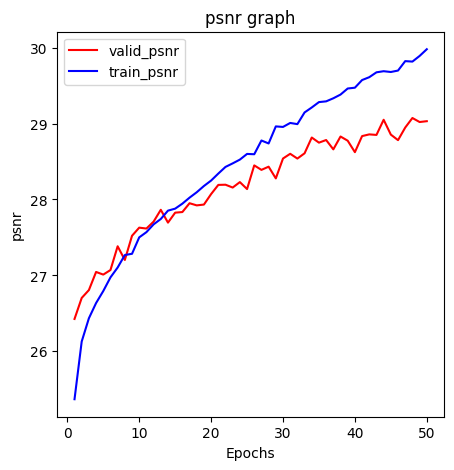

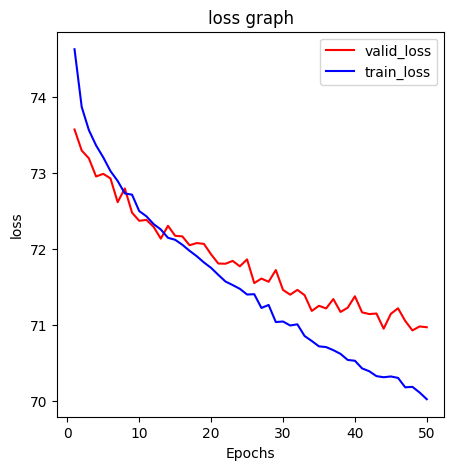

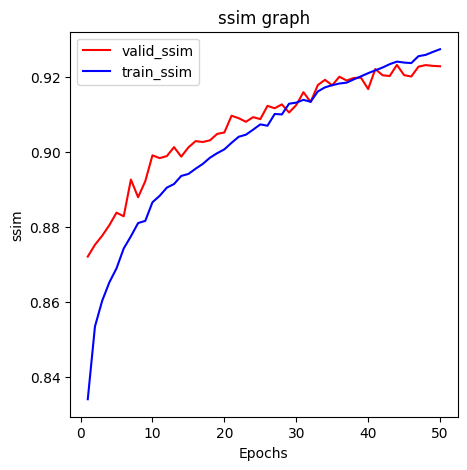

In [15]:
history = trainer.history

epochs = range(1, len(history['train_loss']) + 1)

mode_type = []
plot_type = []

for k, v in history.items():
    metric_type = k.split('_')
    mode_type.append(metric_type[0])
    plot_type.append(metric_type[-1])

mode_type = list(set(mode_type))
plot_type = list(set(plot_type))

for type in plot_type :
    train_str = str(mode_type[0])+'_'+str(type)
    valid_str = str(mode_type[1])+'_'+str(type)
    
    plt.figure(figsize=(5, 5))
    plt.plot(epochs, history[train_str], 'r', label=f'{train_str}')
    plt.plot(epochs, history[valid_str], 'b', label=f'{valid_str}')
    plt.title(f'{type} graph')
    plt.xlabel('Epochs')
    plt.ylabel(f'{type}')
    plt.legend()
    plt.show()

## Test Result Checking

In [ ]:
##### Set model to evaluation mode
from torch.autograd import Variable
cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
# Iterate over a few batches from the test dataset

pth_dir_path = glob(root_path[0] + '/*.pth')[0]
pth_file_path = glob(pth_dir_path + '/**/*.pth', recursive = True)[0]

model = NAFNet(img_channel=img_channel, width=width, middle_blk_num=middle_blk_num,
               enc_blk_nums=enc_blks, dec_blk_nums=dec_blks).to(Configs.device)

model.load_state_dict(torch.load(pth_file_path))
model.to(Configs.device)
model.eval()

total_ssim, total_psnr, total_loss = 0,0,0
length = len(test_dataloader)

for batch_idx, (lr,hr) in enumerate(test_dataloader):
    with torch.no_grad():
        
        #inputs, labels = lr.to(Configs.device), hr.to(Configs.device)
        
        imgs_lr = Variable(lr.type(Tensor))
        imgs_hr = Variable(hr.type(Tensor))

        # Forward pass: Generate high-resolution images
    
        gen_hr = model(imgs_lr)
        
        ssim, mse, psnr, loss = loss_Calc(output_img = gen_hr, sharp_img = imgs_hr, device = Configs.device).metrics()
        
        total_ssim += ssim.item()
        total_psnr += psnr.item()
        total_loss += loss.item()

    # 2개의 batches만 결과 이미지 show
    if batch_idx >= 2:
        continue

    # Visualize a few sample images
    num_samples = min(100, len(imgs_lr))

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 10))
    for i in range(num_samples):
        # Original LR image
        axes[i, 0].imshow(imgs_lr[i].cpu().permute(1, 2, 0).numpy())
        axes[i, 0].set_title("Noise")
        axes[i, 0].axis("off")

        # Ground truth HR image
        axes[i, 1].imshow(imgs_hr[i].cpu().permute(1, 2, 0).numpy())
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")

        # Generated HR image
        axes[i, 2].imshow(gen_hr[i].cpu().permute(1, 2, 0).numpy())
        axes[i, 2].set_title("Generated")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

test_loss = total_loss / length
test_psnr = total_psnr / length
test_ssim = total_ssim / length
    
print(f"\nTest Loss: {test_loss:.4f}, Test PSNR: {test_psnr:.4f}, Test SSIM: {test_ssim:.4f}")